In [110]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import math
from collections import OrderedDict
%matplotlib inline

In [111]:
image_dir = 'D:/Didi-Competition/Kitti/data_object_image_2/training/image_2/'
label_dir = 'D:/Didi-Competition/Kitti/data_object_label_2/training/label_2/'
calib_dir = 'D:/Didi-Competition/Kitti/data_object_calib/training/calib/'
lidar_dir = 'D:/Didi-Competition/Kitti/data_object_velodyne/training/velodyne/'


In [112]:
train_image_list = glob.glob(image_dir+'*.*')
label_list = glob.glob(label_dir+'*.*')
calib_list = glob.glob(calib_dir+'*.*')
lidar_list = glob.glob(lidar_dir+'*.*')
print(len(train_image_list))
print(len(label_list))
print(len(calib_list))
print(len(lidar_list))

7482
7481
7481
7481


# Some helper functions
## Transformations

In [114]:
def rotx(t):
    """Rotation about the x-axis."""
    c = np.cos(t)
    s = np.sin(t)
    return np.array([[1,  0,  0],
                     [0,  c, -s],
                     [0,  s,  c]])

def roty(t):
    """Rotation about the y-axis."""
    c = np.cos(t)
    s = np.sin(t)
    return np.array([[c,  0,  s],
                     [0,  1,  0],
                     [-s, 0,  c]])

def rotz(t):
    """Rotation about the z-axis."""
    c = np.cos(t)
    s = np.sin(t)
    return np.array([[c, -s,  0],
                     [s,  c,  0],
                     [0,  0,  1]])

def transform_from_rot_trans(R, t):
    """Transforation matrix from rotation matrix and translation vector."""
    R = R.reshape(3, 3)
    t = t.reshape(3, 1)
    return np.vstack((np.hstack([R, t]), [0, 0, 0, 1]))


## Label stuff

In [115]:
def load_label(fname):
    lines= open(fname).readlines()
    labels=[]
    for l in lines:
        label=OrderedDict()
        l=l.strip('\n')
        items=l.split(" ")
      #  print(items)
        label['type']=items[0]
        label['truncated']=int(float((items[1])))
        label['occluded']=int(float((items[2])))
        label['alpha']=float((items[3]))
        bbox=[0]*4
        bbox[0]=int(float((items[4])))
        bbox[1]=int(float((items[5])))
        bbox[2]=int(float((items[6])))
        bbox[3]=int(float((items[7])))
        label['bbox']=bbox
        label['height']=float((items[8]))
        label['width']=float((items[9]))
        label['length']=float((items[10]))
        label['pos_x']=float((items[11]))
        label['pos_y']=float((items[12]))
        label['pos_z']=float((items[13]))
        label['rotation_y']=float((items[14]))
     #   label['score']=float((items[15]))
        labels.append(label)
    return labels    

In [116]:
def create_rect(label):
    color='black'
    if label['type']=='Car':
        color='red'
    if label['type']=='Van':
        color='red'   
    if label['type']=='Truck':
        color='red'  
    if label['type']=='Pedestrian':
        color='blue'    
    if label['type']=='Person_sitting':
        color='blue'   
    if label['type']=='Cyclist':
        color='green'    
    if label['type']=='Tram':
        color='yellow'    
    if label['type']=='Misc':
        color='white'  
    
    bb=label['bbox']
    return plt.Rectangle((bb[0], bb[1]), bb[2]-bb[0], bb[3]-bb[1], color=color, fill=False, lw=2)

def show_bb(img,labels):
    plt.figure(figsize=(15,8))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    for l in labels:
        if l['type']!='DontCare':
            plt.gca().add_patch(create_rect(l))
    plt.show()

In [118]:
# some test
labels=load_label(label_list[1])
labels

[OrderedDict([('type', 'Truck'),
              ('truncated', 0),
              ('occluded', 0),
              ('alpha', -1.57),
              ('bbox', [599, 156, 629, 189]),
              ('height', 2.85),
              ('width', 2.63),
              ('length', 12.34),
              ('pos_x', 0.47),
              ('pos_y', 1.49),
              ('pos_z', 69.44),
              ('rotation_y', -1.56)]),
 OrderedDict([('type', 'Car'),
              ('truncated', 0),
              ('occluded', 0),
              ('alpha', 1.85),
              ('bbox', [387, 181, 423, 203]),
              ('height', 1.67),
              ('width', 1.87),
              ('length', 3.69),
              ('pos_x', -16.53),
              ('pos_y', 2.39),
              ('pos_z', 58.49),
              ('rotation_y', 1.57)]),
 OrderedDict([('type', 'Cyclist'),
              ('truncated', 0),
              ('occluded', 3),
              ('alpha', -1.65),
              ('bbox', [676, 163, 688, 193]),
              ('heigh

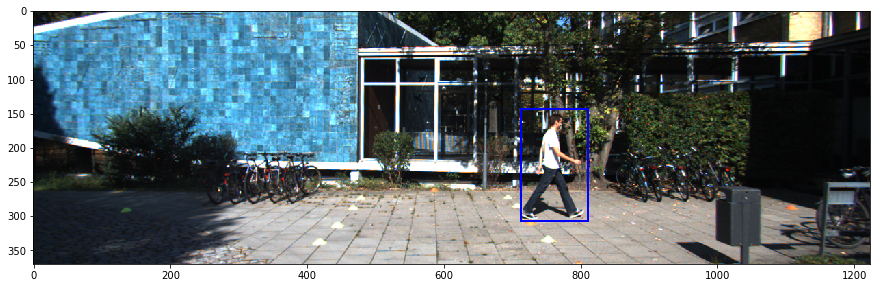

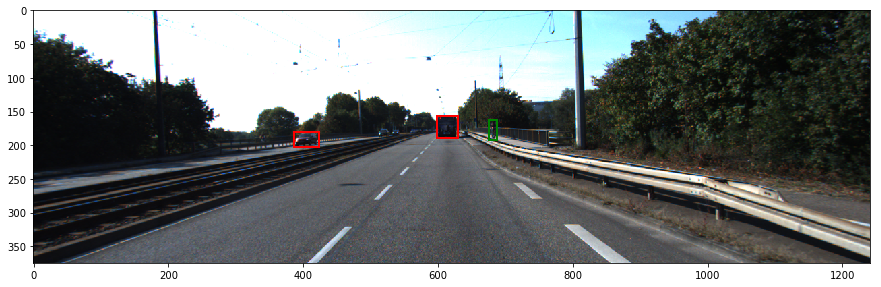

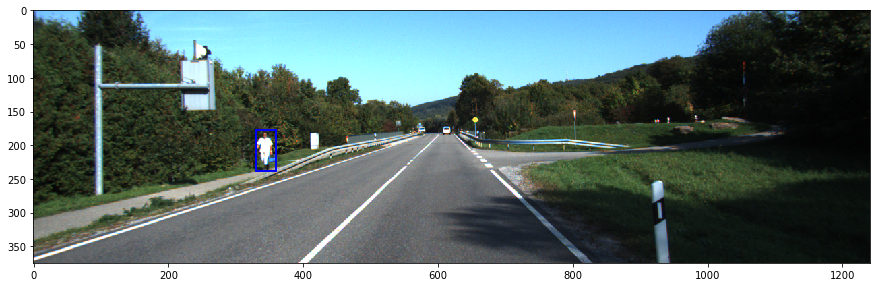

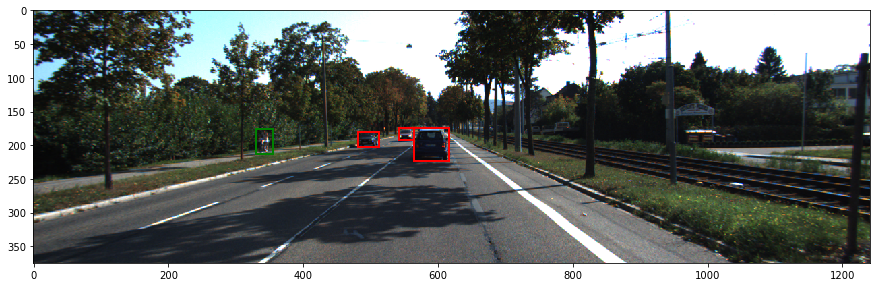

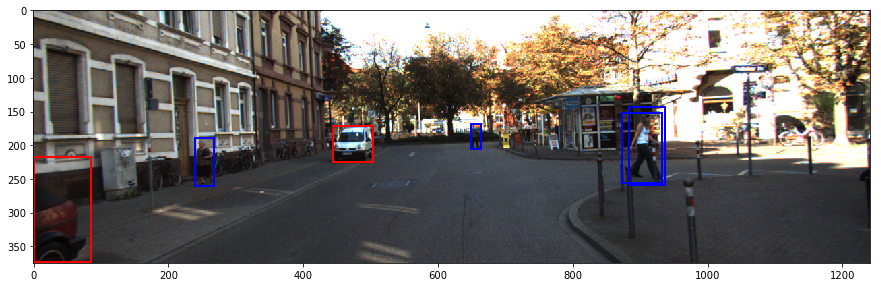

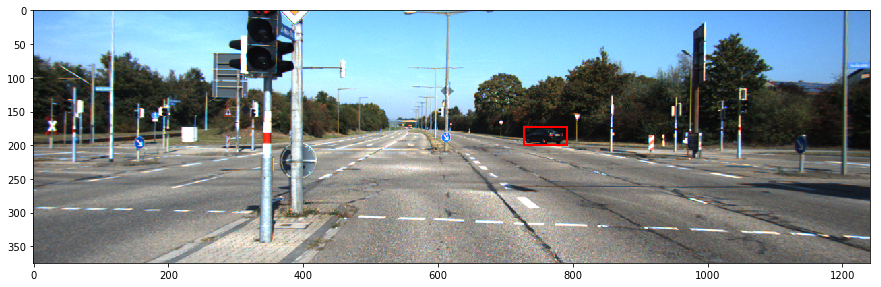

In [119]:
idx=[0,1,5,7,11,17]
for i in idx:
    fname=train_image_list[i]
    labels=load_label(label_list[i])
    img = cv2.imread(fname)
    show_bb(img,labels)

## Load Velodyne data

In [125]:
def load_veloscan(fname):
    scan = np.fromfile(fname, dtype=np.float32)
    return scan.reshape((-1, 4))


In [186]:
i=idx[2]
fname=lidar_list[i]
scan= load_veloscan(fname)

In [187]:
scan[0:1000,0]

array([  5.18139992e+01,   5.18139992e+01,   5.15670013e+01,
         5.16599998e+01,   5.18289986e+01,   5.20839996e+01,
         5.00470009e+01,   5.00009995e+01,   4.97919998e+01,
         4.94729996e+01,   4.92249985e+01,   4.96279984e+01,
         5.18689995e+01,   4.96990013e+01,   5.12439995e+01,
         5.07459984e+01,   4.99949989e+01,   4.99710007e+01,
         4.87459984e+01,   4.88250008e+01,   4.85960007e+01,
         4.91010017e+01,   4.91520004e+01,   4.94150009e+01,
         5.01899986e+01,   4.90629997e+01,   4.90800018e+01,
         4.89290009e+01,   4.92910004e+01,   4.73510017e+01,
         4.72960014e+01,   4.73590012e+01,   4.72760010e+01,
         4.74720001e+01,   4.70859985e+01,   4.65439987e+01,
         4.66269989e+01,   4.78050003e+01,   4.69930000e+01,
         4.68390007e+01,   4.70740013e+01,   4.55979996e+01,
         4.54749985e+01,   4.63629990e+01,   4.62719994e+01,
         4.61660004e+01,   4.58730011e+01,   4.65589981e+01,
         4.62169991e+01,

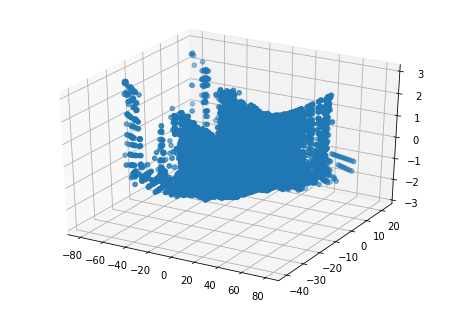

In [189]:
from mpl_toolkits.mplot3d import Axes3D
import pylab
x=scan[0:10000,0]
y=scan[0:10000,1]
z=scan[0:10000,2]

x=scan[:,0]
y=scan[:,1]
z=scan[:,2]
fig = pylab.figure()
ax = Axes3D(fig)
ax.scatter(x,y,z)
plt.show()

## Load calibration data 
Code based on matlab example readCalibration.m

In [151]:
def read_calib(fname):
    calib = {}
    lines= open(fname).readlines() 
    for l in lines:
        l=l.strip('\n')
        if len(l)>0:
            key, value = l.split(':', 1)
            try:
                calib[key] = np.array([float(x) for x in value.split()])
            except ValueError:
                pass
    return calib

In [154]:
i=idx[1]
fname=calib_list[i]
calib= read_calib(fname)
calib


{'P0': array([ 721.5377,    0.    ,  609.5593,    0.    ,    0.    ,  721.5377,
         172.854 ,    0.    ,    0.    ,    0.    ,    1.    ,    0.    ]),
 'P1': array([ 721.5377,    0.    ,  609.5593, -387.5744,    0.    ,  721.5377,
         172.854 ,    0.    ,    0.    ,    0.    ,    1.    ,    0.    ]),
 'P2': array([  7.21537700e+02,   0.00000000e+00,   6.09559300e+02,
          4.48572800e+01,   0.00000000e+00,   7.21537700e+02,
          1.72854000e+02,   2.16379100e-01,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   2.74588400e-03]),
 'P3': array([  7.21537700e+02,   0.00000000e+00,   6.09559300e+02,
         -3.39524200e+02,   0.00000000e+00,   7.21537700e+02,
          1.72854000e+02,   2.19993600e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   2.72990500e-03]),
 'R0_rect': array([ 0.9999239 ,  0.00983776, -0.00744505, -0.0098698 ,  0.9999421 ,
        -0.00427846,  0.00740253,  0.00435161,  0.9999631 ]),
 'Tr_imu_to_velo': array([  9.